In [ ]:
#SPY  ticker  S&P 500

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math
from sklearn.preprocessing import MinMaxScaler

from yahoo_fin.stock_info import get_data

In [ ]:
#interval: {“1d”, “1wk”, “1mo”}. Refers to the interval to sample the data: “1d”= daily, “1wk”= weekly, “1mo”=monthly.

In [3]:
api_df= get_data("spy", start_date="12/04/2010", end_date="07/04/2022", index_as_date = False, interval="1d")
api_df

,date,open,high,low,close,adjclose,volume,ticker
0,2010-12-06,122.629997,123.040001,122.500000,122.760002,98.031464,103050500,SPY
1,2010-12-07,123.940002,124.010002,122.760002,122.830002,98.087341,206581000,SPY
2,2010-12-08,122.980003,123.379997,122.410004,123.279999,98.446701,138019200,SPY
3,2010-12-09,123.970001,124.019997,123.150002,123.760002,98.830002,123705100,SPY
4,2010-12-10,124.139999,124.599998,123.730003,124.480003,99.404984,117571700,SPY
...,...,...,...,...,...,...,...,...
2908,2022-06-27,391.049988,391.359985,387.440002,388.589996,388.589996,66009600,SPY
2909,2022-06-28,390.230011,393.160004,380.529999,380.649994,380.649994,86548900,SPY
2910,2022-06-29,381.230011,382.269989,378.420013,380.339996,380.339996,65676000,SPY
2911,2022-06-30,376.239990,380.660004,372.559998,377.250000,377.250000,112508300,SPY


In [4]:
#print the summary 
print(api_df.describe())

              open         high          low        close     adjclose  \
count  2913.000000  2913.000000  2913.000000  2913.000000  2913.000000   
mean    243.528163   244.816334   242.099979   243.550573   224.588176   
std      92.772372    93.333788    92.101348    92.748134    99.523727   
min     108.349998   112.580002   107.430000   109.930000    89.531166   
25%     174.919998   175.929993   174.429993   175.169998   149.112488   
50%     216.309998   216.880005   215.360001   216.339996   194.792480   
75%     290.920013   291.690002   289.410004   290.690002   275.643311   
max     479.220001   479.980011   476.059998   477.709991   474.182190   

             volume  
count  2.913000e+03  
mean   1.119149e+08  
std    6.515635e+07  
min    2.027000e+07  
25%    6.824400e+07  
50%    9.555530e+07  
75%    1.358350e+08  
max    7.178287e+08  


In [5]:
#prep the data 
api_df.set_index(pd.DatetimeIndex(api_df['date']), inplace=True)

In [6]:
#Keep the close for 2014-19
api_df = api_df[['close']]
api_df

,close
date,
2010-12-06,122.760002
2010-12-07,122.830002
2010-12-08,123.279999
2010-12-09,123.760002
2010-12-10,124.480003
...,...
2022-06-27,388.589996
2022-06-28,380.649994
2022-06-29,380.339996


In [7]:
print (api_df.index.max())

2022-07-01 00:00:00


In [8]:
data = api_df.filter(['close'])
dataset = data.values

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

training_data_len =math.ceil(len(dataset) *.7)
train_data =scaled_data[0:training_data_len , : ]


X_train_data = []
y_train_data = []

for i in range(1500,len(train_data)):
    X_train_data=list(X_train_data)
    y_train_data=list(y_train_data)
    X_train_data.append(train_data[i-1500:i,0])
    y_train_data.append(train_data[i,0])
    
    X_train_data1, y_train_data1 = np.array(X_train_data), np.array(y_train_data)
    
    X_train_data2 = np.reshape(X_train_data1,(X_train_data1.shape[0],X_train_data1.shape[1],1))

   
    
#1500 = number of days you can change it accordingly. 

# There will be a total of 60 values, 1st column will contain an index of 0-59
# The second will have an index of 1-60 ++_
# the y_train has the 60 st value on c1 and c2 will have 61++

In [9]:
#Build the LSTM MODEL 

model = Sequential()

model.add(LSTM(units=50, return_sequences=True,input_shape=(X_train_data2.shape[1],1)))

model.add(LSTM(units=50, return_sequences=False))

model.add(Dense(units=25))

model.add(Dense(units=1))

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_data2, y_train_data1, batch_size=1, epochs=1)

540/540 [==============================] - 334s 594ms/step - loss: 0.0012


In [11]:
test_data = scaled_data[training_data_len -1500: , : ]

X_test = []

y_test = dataset[training_data_len : , : ]

for i in range(1500,len(test_data)):
    
    X_test.append(test_data[i-1500:i,0])

X_test = np.array(X_test)

X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))

predictions = model.predict(X_test)

predictions = scaler.inverse_transform(predictions)

28/28 [==============================] - 10s 319ms/step


In [12]:
# Error calculation where RMSE = root mean squared error 

rmse=np.sqrt(np.mean(((predictions-y_test)**2)))

In [13]:
print(rmse)

13.761562930155131


C:\Users\rctay\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


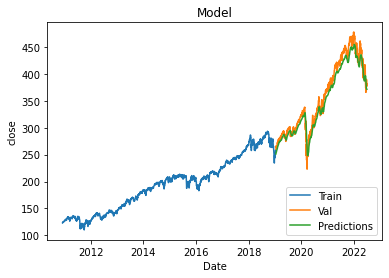

In [16]:
#Predict and visualize 

train = api_df[:training_data_len]

valid = api_df[training_data_len:]

valid['Predictions'] = predictions

plt.title('Model')

plt.xlabel('Date')

plt.ylabel('close')

plt.plot(train['close'])

plt.plot(valid[['close', 'Predictions']])

plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')

plt.show()

<AxesSubplot:xlabel='date'>

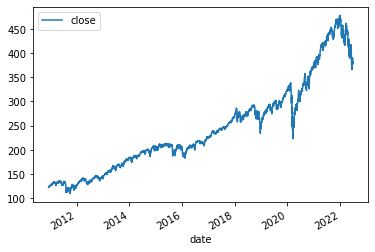

In [17]:
api_df.plot()